**Setup of the Jupyter Notebook Environment**

In [12]:
import os
import time
import glob
import numpy as np
import pandas as pd
import cv2
import seaborn as sns

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from sklearn import metrics
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

In [3]:
# init deterministic seed
seed_value = 1234
np.random.seed(seed_value) # set numpy seed

In [4]:
# set cpu or gpu enabled device
device = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu').type

# init deterministic GPU and CPU seed
torch.manual_seed(seed_value) # set pytorch seed

# log type of device enabled

print('[LOG] notebook with {} computation enabled'.format(str(device)))

[LOG] notebook with cpu computation enabled


In [4]:
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


In [5]:
# mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
# check whether directory exists
print(os.listdir('/content/drive/MyDrive/Colab Notebooks/SalmonScan'))

['Raw', 'Augmented']


**Preparing the dataset**

In [7]:
# list all images files
main_dir = '/content/drive/MyDrive/Colab Notebooks/SalmonScan'

image_paths = glob.glob(os.path.join(main_dir, '**', '*.jpg'), recursive=True)
image_paths += glob.glob(os.path.join(main_dir, '**', '*.png'), recursive=True)

print(f"Found {len(image_paths)} images.")
print("Sample paths:", image_paths[:3])  # Print first 3 paths as a sample

Found 1322 images.
Sample paths: ['/content/drive/MyDrive/Colab Notebooks/SalmonScan/Raw/FreshFish/a_salmon_fresh_16.png', '/content/drive/MyDrive/Colab Notebooks/SalmonScan/Raw/FreshFish/a_salmon_fresh_01.png', '/content/drive/MyDrive/Colab Notebooks/SalmonScan/Raw/FreshFish/a_salmon_fresh_14.png']


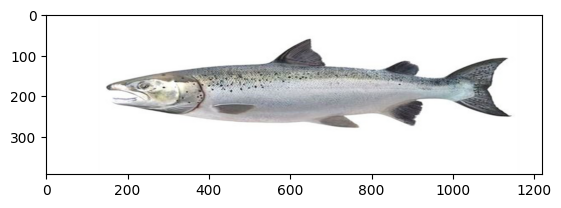

In [8]:
# load the first image from the list
img = mpimg.imread(image_paths[0])
plt.imshow(img)

In [9]:
# create a list of tuples: (image_path, label)
labeled_data = []
for path in image_paths:
    label = os.path.basename(os.path.dirname(path))
    labeled_data.append((path, label))

for path, label in labeled_data[:5]:
    print(f"Image: {path}, Label: {label}") # Print the first 5 entries to verify

Image: /content/drive/MyDrive/Colab Notebooks/SalmonScan/Raw/FreshFish/a_salmon_fresh_16.png, Label: FreshFish
Image: /content/drive/MyDrive/Colab Notebooks/SalmonScan/Raw/FreshFish/a_salmon_fresh_01.png, Label: FreshFish
Image: /content/drive/MyDrive/Colab Notebooks/SalmonScan/Raw/FreshFish/a_salmon_fresh_14.png, Label: FreshFish
Image: /content/drive/MyDrive/Colab Notebooks/SalmonScan/Raw/FreshFish/a_salmon_fresh_04.png, Label: FreshFish
Image: /content/drive/MyDrive/Colab Notebooks/SalmonScan/Raw/FreshFish/a_salmon_fresh_06.png, Label: FreshFish


In [10]:
# transform the list into a dataframe
df = pd.DataFrame(labeled_data, columns=['path', 'label'])

print(df.head())

                                                path      label
0  /content/drive/MyDrive/Colab Notebooks/SalmonS...  FreshFish
1  /content/drive/MyDrive/Colab Notebooks/SalmonS...  FreshFish
2  /content/drive/MyDrive/Colab Notebooks/SalmonS...  FreshFish
3  /content/drive/MyDrive/Colab Notebooks/SalmonS...  FreshFish
4  /content/drive/MyDrive/Colab Notebooks/SalmonS...  FreshFish


In [11]:
# initialize lists to store images and labels
images = []
labels = []

for index, row in df.iterrows():
    image = cv2.imread(row['path'])
    image = cv2.resize(image, (600, 250))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    images.append(image)
    labels.append(row['label'])

# convert to NumPy arrays
images = np.array(images)
labels = np.array(labels)

images = images.astype('float32') / 255.0

print("Images shape:", images.shape)
print("Labels shape:", labels.shape)

Images shape: (1322, 250, 600, 3)
Labels shape: (1322,)


In [12]:
# encode labels
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)

print("Encoded labels:", encoded_labels[:5])

Encoded labels: [0 0 0 0 0]


In [13]:
# convert images and labels to PyTorch tensors
images_tensor = torch.from_numpy(images).float().permute(0, 3, 1, 2)
labels_tensor = torch.from_numpy(encoded_labels).float().view(-1, 1)

In [14]:
# create custom dataset
class SalmonDataset(Dataset):
    def __init__(self, images, labels):
        self.images = images
        self.labels = labels

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        return self.images[idx], self.labels[idx]

In [15]:
# split into training and validation datasets
train_images, test_images, train_labels, test_labels = train_test_split(
    images_tensor, labels_tensor, test_size=0.3, random_state=42
)

In [16]:
# create dataloaders
train_dataset = SalmonDataset(train_images, train_labels)
test_dataset = SalmonDataset(test_images, test_labels)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [17]:
len(train_loader)

29

In [18]:
len(test_loader)

13

In [19]:
# define a function for plot
def plot_images(images, n_rows=1):
    fig, axs = plt.subplots(n_rows, images.size(0) // n_rows)
    for ax, img in zip(axs.flat, images):
        ax.matshow(img[0].cpu().numpy(), cmap=plt.cm.Greys)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
    plt.tight_layout(w_pad=0)

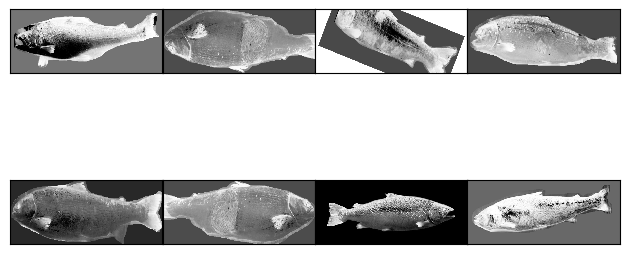

In [20]:
images, labels = next(iter(train_loader))
plot_images(images[:8], n_rows=2)

**Defining the CNN architecture**

In [21]:
# architecture of the CNN
class SalmonNet(nn.Module):
    def __init__(self):
        super(SalmonNet, self).__init__()

        self.convolutional_layer = nn.Sequential(

            # convolutional layer 1
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),

            # max pooling layer 1
            nn.MaxPool2d(kernel_size=2, stride=2),

            # convolutional layer 2
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),

            # max pooling layer 2
            nn.MaxPool2d(kernel_size=2, stride=2),

            # convolutional layer 3
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),

            # max pooling layer 3
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self.linear_layer = nn.Sequential(
            nn.Linear(in_features=128 * 31 * 75, out_features=128),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(in_features=128, out_features=1)
        )

    def forward(self, x, verbose=False):
        x = self.convolutional_layer(x)
        x = x.view(x.size(0), -1)
        x = self.linear_layer(x)
        return x

In [22]:
# check the shape of the output of the CNN
def test_Net_shapes():
    net = SalmonNet()
    net.to(device)

    with torch.no_grad():
        images, labels = next(iter(train_loader))
        images = images.to(device)
        print('Shape of the input tensor:', images.shape)

        y = net(images, verbose=True)
        print('Shape of the output tensor:', y.shape)

    print('Success')

test_Net_shapes()

Shape of the input tensor: torch.Size([32, 3, 250, 600])
Shape of the output tensor: torch.Size([32, 1])
Success


In [23]:
# instantiate a network model to be trained
net = SalmonNet()
net = net.to(device) #as specified in code cell 3

**Training the CNN model**

In [24]:
# a function for computing the accuracy on the val dataset
def compute_accuracy(net, test_loader):
    net.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = net(images)
            predicted = (outputs > 0.5).float()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct / total

In [25]:
# defining the loss function
criterion = nn.BCEWithLogitsLoss()

# defining the optimiser
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

# init collection of training epoch losses
train_losses = []


best_val_accuracy = 0.0

# setting the model in training mode
net.train()

SalmonNet(
  (convolutional_layer): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (linear_layer): Sequential(
    (0): Linear(in_features=297600, out_features=128, bias=True)
    (1): ReLU(inplace=

In [26]:
# Implement the training loop
epochs = 10
for epoch in range(epochs):

    # init the time
    time0 = time.time()

    # init collection of mini-batch losses
    running_loss=[]

    # iterate over all-mini batches
    for batch_idx, data in enumerate(train_loader,0):

        # push mini-batch data to computation device
        inputs,target = data
        inputs,target = inputs.to(device), target.to(device)

        # run forward pass through the network
        outputs = net(inputs, verbose=True)

        # reset graph gradients
        optimizer.zero_grad()

        # determine classification loss
        loss = criterion(outputs,target)

        # run backward pass to update the weights
        loss.backward()

        # update network paramaters
        optimizer.step()

        # collect mini-batch reconstruction loss
        running_loss.append(loss.item())

    # determine mean min-batch loss of epoch
    train_loss = np.mean(running_loss)
    train_losses.append(train_loss)

    # print epoch loss
    if epoch % 1 == 0:
        print(
            f"epoch:{epoch+1}",
            "\ttrain_loss:",
            round(train_loss, 3),
            "\taccuracy:",
            round(compute_accuracy(net, test_loader),3),
            "\tUsed_time:",
                round((time.time()-time0)/60,3)
        )

KeyboardInterrupt: 

**Evaluating the CNN**

In [ ]:
# saving the best model
model_path = os.path.join('/content/drive/MyDrive/Colab Notebooks/SalmonScan', 'best_salmon_model.pth')
torch.save(net.state_dict(), model_path)

In [ ]:
# loading the best model
model = SalmonNet()
model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))

In [ ]:
# setting them model in evaluation mode
model.eval

In [ ]:
# storing the predicted classes on the test dataset
predictions = []
with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        predicted = (outputs > 0.5).float()
        predictions.extend(predicted.cpu().numpy())

In [ ]:
# calculate metrics
accuracy = accuracy_score(test_dataset.targets, predictions)
precision = precision_score(test_dataset.targets, predictions)
recall = recall_score(test_dataset.targets, predictions)
f1 = f1_score(test_dataset.targets, predictions)

# Print the results
print(f'Accuracy: {accuracy:.3f}')
print(f'Precision: {precision:.3f}')
print(f'Recall: {recall:.3f}')
print(f'F1-Score: {f1:.3f}')

In [ ]:
# inspecting the confusion matrix
cm = confusion_matrix(test_dataset.targets, predictions)

plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='YlOrRd_r',
            xticklabels=["FreshFish", "InfectedFish"],
            yticklabels=["FreshFish", "InfectedFish"])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Salmon Scan Confusion Matrix')
plt.show()